In [1]:
# Cell 1 — Device & AMP
import torch, os, numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_mixed_precision = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7
print(f"🚀 Using device: {device}")
print("⚡ Mixed precision ON" if use_mixed_precision else "🔄 Full precision")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"🔥 GPU Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")
try:
    scaler = torch.amp.GradScaler('cuda') if use_mixed_precision else None
except Exception:
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None


🚀 Using device: cuda
⚡ Mixed precision ON
🔥 GPU Memory: 15.8 GB


In [2]:
# Cell 2 — Load index.csv (must include organ column)
from pathlib import Path
import pandas as pd

INDEX_CSV = Path("/kaggle/input/55k-index/index.csv")  # <-- EDIT if needed
assert INDEX_CSV.exists(), f"Missing {INDEX_CSV}. Rebuild your scanner to include 'organ' column."

df = pd.read_csv(INDEX_CSV)
assert {"image_path","mask_path","organ"}.issubset(df.columns), "index.csv must have image_path, mask_path, organ"
print(f"📊 Total rows: {len(df)}")


📊 Total rows: 54280


In [3]:
# Cell 3 — Base MedicalDataset (same as your earlier one, tiny fixes for .copy())
from PIL import Image
import numpy as np
import torch

class MedicalDataset(torch.utils.data.Dataset):
    def __init__(self, frame, resize_to=(320,320), training=True):
        self.df = frame.reset_index(drop=True)
        self.resize_to = resize_to
        self.training = training

    def __len__(self): return len(self.df)

    def _read_img(self, p):
        p = Path(p)
        if p.suffix.lower() in [".npy", ".npz"]:
            arr = np.load(p) if p.suffix.lower()==".npy" else np.load(p)["arr_0"]
            if arr.ndim == 2:
                img = Image.fromarray(arr.astype(np.float32)).convert("L")
                img = img.resize(self.resize_to, Image.BILINEAR)
                arr = np.asarray(img)[None, ...]              # [1,H,W]
                arr = np.repeat(arr, 3, axis=0)               # [3,H,W]
            else:
                img = Image.fromarray(arr.astype(np.float32))
                img = img.resize(self.resize_to, Image.BILINEAR)
                arr = np.asarray(img).transpose(2,0,1)        # [3,H,W]
        else:
            img = Image.open(p).convert("RGB")
            img = img.resize(self.resize_to, Image.BILINEAR)
            arr = np.asarray(img).transpose(2,0,1)            # [3,H,W]
        arr = arr.copy()                                       # writable
        return torch.from_numpy(arr).float() / 255.0           # [3,H,W]

    def _read_mask(self, p):
        p = Path(p)
        if p.suffix.lower() in [".npy", ".npz"]:
            arr = np.load(p) if p.suffix.lower()==".npy" else np.load(p)["arr_0"]
            if arr.ndim == 3: arr = arr[...,0]
            m = Image.fromarray(arr.astype(np.float32))
        else:
            m = Image.open(p).convert("L")
        m = m.resize(self.resize_to, Image.NEAREST)
        m = (np.asarray(m) > 0).astype(np.float32)
        m = m.copy()
        return torch.from_numpy(m)[None, ...]                  # [1,H,W]

    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = self._read_img(r.image_path)
        msk = self._read_mask(r.mask_path)
        # simple aug: horizontal flip
        if self.training and torch.rand(()) < 0.5:
            img = torch.flip(img, dims=[2]); msk = torch.flip(msk, dims=[2])
        return {"image": img, "mask": msk, "organ": r.organ}


In [4]:
# Cell 4 — Prompt utilities + PromptedDataset (4th channel = soft box prior)
import torch.nn.functional as F

def bbox_from_mask_tensor(msk):  # msk: [1,H,W]
    y, x = torch.where(msk[0] > 0.5)
    if len(x) == 0:
        H, W = msk.shape[-2:]
        return (0, 0, W-1, H-1)
    return (int(x.min()), int(y.min()), int(x.max()), int(y.max()))

def make_soft_box_prior(h, w, box, pad=2, blur=5):
    x1,y1,x2,y2 = [int(v) for v in box]
    x1 = max(0, x1-pad); y1 = max(0, y1-pad)
    x2 = min(w-1, x2+pad); y2 = min(h-1, y2+pad)
    prior = torch.zeros((h,w), dtype=torch.float32)
    prior[y1:y2+1, x1:x2+1] = 1.0
    if blur and blur > 0:
        k = blur if blur % 2 == 1 else blur + 1
        prior = F.avg_pool2d(prior.unsqueeze(0).unsqueeze(0), kernel_size=k, stride=1, padding=k//2).squeeze(0).squeeze(0)
    return prior.clamp(0,1)

class PromptedDataset(torch.utils.data.Dataset):
    """Wraps MedicalDataset; returns 4-ch input: [3 RGB + 1 soft box prior]."""
    def __init__(self, base_ds, jitter=0.08):
        self.base = base_ds
        self.jitter = jitter
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        sample = self.base[i]  # {"image":[3,H,W], "mask":[1,H,W], "organ": str}
        img, msk, organ = sample["image"], sample["mask"], sample["organ"]
        _, H, W = img.shape
        x1,y1,x2,y2 = bbox_from_mask_tensor(msk)
        dx = int(self.jitter * max(1, x2 - x1 + 1))
        dy = int(self.jitter * max(1, y2 - y1 + 1))
        x1 = max(0, x1 - dx); y1 = max(0, y1 - dy)
        x2 = min(W-1, x2 + dx); y2 = min(H-1, y2 + dy)
        prior = make_soft_box_prior(H, W, (x1,y1,x2,y2), pad=2, blur=5).unsqueeze(0)  # [1,H,W]
        img4 = torch.cat([img, prior], dim=0)  # [4,H,W]
        return {"image": img4, "mask": msk, "organ": organ}


In [5]:
# Cell 5 — Split → wrap with PromptedDataset → loaders (optionally brain-only)
from torch.utils.data import DataLoader, WeightedRandomSampler

# Optional: brain-only training to speed convergence
brain_only = False
df_use = df.copy()
if brain_only:
    df_use = df_use[df_use["organ"].str.lower()=="brain"].reset_index(drop=True)
    print(f"🧠 Brain-only: {len(df_use)} rows")

# Split
idx = np.random.RandomState(123).permutation(len(df_use))
split = int(0.85 * len(df_use))
train_df = df_use.iloc[idx[:split]].reset_index(drop=True)
val_df   = df_use.iloc[idx[split:]].reset_index(drop=True)

# Base datasets (3-> then wrapped to 4ch)
base_train = MedicalDataset(train_df, resize_to=(320,320), training=True)
base_val   = MedicalDataset(val_df,   resize_to=(320,320), training=False)
train_ds = PromptedDataset(base_train, jitter=0.08)  # 8% jitter
val_ds   = PromptedDataset(base_val,   jitter=0.00)  # no jitter in val

# Optional: balanced sampling by organ (useful if not brain_only)
use_balanced = not brain_only
sampler = None
if use_balanced:
    counts_train = train_df["organ"].value_counts()
    inv_freq = {k: 1.0 / v for k,v in counts_train.items()}
    w = train_df["organ"].map(inv_freq).values
    weights = torch.as_tensor(w, dtype=torch.double)
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

NUM_WORKERS = 2
BATCH_SIZE  = 4
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    sampler=sampler if use_balanced else None,
    shuffle=(sampler is None),
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=(NUM_WORKERS>0),
    prefetch_factor=(2 if NUM_WORKERS>0 else None),
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=(NUM_WORKERS>0),
    prefetch_factor=(2 if NUM_WORKERS>0 else None),
)
print(f"train: {len(train_ds)} | val: {len(val_ds)} | balanced={use_balanced}")


train: 46138 | val: 8142 | balanced=True


In [6]:
# Cell 6 — Student model (4-ch input)
import torch.nn as nn

class EfficientStudentModel(nn.Module):
    def __init__(self, input_channels=4, output_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16), nn.ReLU6(inplace=True),
            self._sep(16, 32, 2),
            self._sep(32, 64, 2),
            self._sep(64, 128, 2),
            self._sep(128, 256, 1),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.ReLU6(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.ReLU6(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32), nn.ReLU6(inplace=True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16), nn.ReLU6(inplace=True),
            nn.Conv2d(16, output_channels, 1),
        )
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)

    def _sep(self, in_ch, out_ch, stride):
        return nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, stride=stride, padding=1, groups=in_ch),
            nn.BatchNorm2d(in_ch), nn.ReLU6(inplace=True),
            nn.Conv2d(in_ch, out_ch, 1),
            nn.BatchNorm2d(out_ch), nn.ReLU6(inplace=True),
        )

    def forward(self, x):
        f = self.encoder(x)
        y = self.decoder(f)
        if y.shape[-2:] != x.shape[-2:]:
            y = torch.nn.functional.interpolate(y, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return y

    def count_trainable_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

student_model = EfficientStudentModel(input_channels=4).to(device)
print(f"👨‍🎓 Student params: {student_model.count_trainable_parameters():,}")


👨‍🎓 Student params: 745,521


In [8]:
# Cell 7 — Expand 3ch weights to 4ch and load
BEST_STATE = "/kaggle/input/best-student-state/pytorch/default/1/best_student_1.pt"          # <-- EDIT if needed
BEST_FULL  = "/kaggle/input/best-student-kdfull-1/pytorch/default/1/best_student_kd_full_1.pt"     # <-- EDIT if needed

def load_3ch_into_4ch_student(model4):
    sd = None
    if os.path.exists(BEST_STATE):
        ck = torch.load(BEST_STATE, map_location="cpu")
        sd = ck.get("student", ck)
        print("Found best_student.pt (state_dict).")
    elif os.path.exists(BEST_FULL):
        try:
            m3 = torch.load(BEST_FULL, map_state_dict=False, map_location="cpu")
            sd = m3.state_dict()
            print("Found best_student_full.pt (full model).")
        except Exception as e:
            print("Full model load failed:", e)

    if sd is None:
        print("ℹ️ No previous student weights — training 4ch from scratch.")
        return

    key = "encoder.0.weight"  # first conv
    if key in sd and sd[key].shape[1] == 3:
        w3 = sd[key]                              # [out,3,kh,kw]
        w4 = torch.zeros((w3.shape[0], 4, w3.shape[2], w3.shape[3]))
        w4[:, :3, :, :] = w3
        sd[key] = w4
        print("✅ Expanded first conv 3→4 channels.")
    else:
        print("ℹ️ First conv was not 3ch; loading with strict=False.")

    missing, unexpected = student_model.load_state_dict(sd, strict=False)
    if missing:    print("missing keys (first 5):", list(missing)[:5])
    if unexpected: print("unexpected keys (first 5):", list(unexpected)[:5])
    print("✅ Loaded previous weights into 4ch model.")

load_3ch_into_4ch_student(student_model)


Found best_student.pt (state_dict).
✅ Expanded first conv 3→4 channels.
✅ Loaded previous weights into 4ch model.


In [9]:
# Cell 8 — Losses (supervised composite; targets [B,1,H,W])
import torch.nn.functional as F
import torch.nn as nn
import torch

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6): super().__init__(); self.eps = eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        tgt = targets.float()
        inter = (probs * tgt).sum(dim=(1,2,3))
        union = probs.sum(dim=(1,2,3)) + tgt.sum(dim=(1,2,3))
        dice = (2*inter + self.eps) / (union + self.eps)
        return 1.0 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0): super().__init__(); self.gamma=gamma
    def forward(self, logits, targets):
        tgt = targets.float()
        bce = F.binary_cross_entropy_with_logits(logits, tgt, reduction='none')
        pt = torch.exp(-bce)
        return ((1-pt)**self.gamma * bce).mean()

def sobel_edge_map(t):
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32, device=t.device).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32, device=t.device).view(1,1,3,3)
    gx = F.conv2d(t, kx, padding=1); gy = F.conv2d(t, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

class BoundaryLoss(nn.Module):
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits); fg = targets.float()
        return F.l1_loss(sobel_edge_map(probs), sobel_edge_map(fg))

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()
focal_loss = FocalLoss()
boundary_loss = BoundaryLoss()

def composite_loss(logits, targets):
    return (0.4*bce_loss(logits, targets.float()) +
            0.3*dice_loss(logits, targets) +
            0.2*focal_loss(logits, targets) +
            0.1*boundary_loss(logits, targets))


In [10]:
# Cell 9 — Optimizer & one epoch supervised fine-tune (prompt-aware 4ch)
import math, time

learning_rate = 2e-4
weight_decay  = 1e-5
optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def train_one_epoch_prompt(loader, optimizer, scaler=None, max_norm=1.0, log_every=200):
    student_model.train()
    logs_sum, n = {}, 0
    for step, batch in enumerate(loader):
        imgs = batch["image"].to(device, non_blocking=True)   # [B,4,H,W]
        msk  = batch["mask"].to(device, non_blocking=True)    # [B,1,H,W]

        optimizer.zero_grad(set_to_none=True)
        if torch.cuda.is_available() and use_mixed_precision and scaler is not None:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                logits = student_model(imgs)
                loss = composite_loss(logits, msk)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm)
            scaler.step(optimizer); scaler.update()
        else:
            logits = student_model(imgs)
            loss = composite_loss(logits, msk)
            loss.backward()
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm)
            optimizer.step()

        logs_sum["loss"] = logs_sum.get("loss", 0.0) + float(loss.detach())
        n += 1
        if (step+1) % log_every == 0:
            print(f"[{step+1}/{len(loader)}] loss={logs_sum['loss']/n:.4f}")
    return {"loss": logs_sum["loss"]/max(n,1)}

@torch.no_grad()
def quick_eval(loader, thr=0.5, max_batches=4):
    student_model.eval()
    iou_sum, c = 0.0, 0
    for i, batch in enumerate(loader):
        if i >= max_batches: break
        imgs = batch["image"].to(device, non_blocking=True)
        msk  = batch["mask"].to(device, non_blocking=True)
        pr   = (torch.sigmoid(student_model(imgs)) > thr).float()
        inter = (pr*msk).sum(dim=(1,2,3))
        union = (pr+msk - pr*msk).sum(dim=(1,2,3)).clamp_min(1e-6)
        iou_sum += (inter/union).mean().item(); c += 1
    if c: print(f"🔎 QuickEval IoU@{thr}: {iou_sum/c:.4f}")


In [12]:
# Cell 10 — Fine-tune 1–2 epochs (prompt-aware)
EPOCHS = 1  # set to 2 if you have time
best_loss = float("inf")
SAVE_FULL = "/kaggle/working/best_student_prompt_full.pt"  # <-- output

for ep in range(1, EPOCHS+1):
    print(f"\n🔁 Prompt-aware epoch {ep}/{EPOCHS}")
    logs = train_one_epoch_prompt(train_loader, optimizer, scaler=scaler, max_norm=1.0, log_every=400)
    quick_eval(val_loader, max_batches=4)
    if logs["loss"] < best_loss:
        best_loss = logs["loss"]
        try:
            torch.save(student_model, SAVE_FULL)
            print(f"💾 Saved best prompt-aware student → {SAVE_FULL}")
        except Exception as e:
            print("⚠️ Could not save full model:", e)
print("✅ Prompt-aware fine-tune complete.")



🔁 Prompt-aware epoch 1/1
[400/11535] loss=0.0891
[800/11535] loss=0.0870
[1200/11535] loss=0.0871
[1600/11535] loss=0.0871
[2000/11535] loss=0.0859
[2400/11535] loss=0.0861
[2800/11535] loss=0.0855
[3200/11535] loss=0.0855
[3600/11535] loss=0.0856
[4000/11535] loss=0.0856
[4400/11535] loss=0.0853
[4800/11535] loss=0.0854
[5200/11535] loss=0.0851
[5600/11535] loss=0.0849
[6000/11535] loss=0.0848
[6400/11535] loss=0.0847
[6800/11535] loss=0.0846
[7200/11535] loss=0.0842
[7600/11535] loss=0.0841
[8000/11535] loss=0.0839
[8400/11535] loss=0.0838
[8800/11535] loss=0.0836
[9200/11535] loss=0.0834
[9600/11535] loss=0.0833
[10000/11535] loss=0.0832
[10400/11535] loss=0.0831
[10800/11535] loss=0.0830
[11200/11535] loss=0.0829
🔎 QuickEval IoU@0.5: 0.5661
💾 Saved best prompt-aware student → /kaggle/working/best_student_prompt_full.pt
✅ Prompt-aware fine-tune complete.


In [16]:
# Cell 11 — Inference with user box → build 4th channel prior → predict
@torch.no_grad()
def infer_with_box(student_model, img_rgb, user_box, device):
    """
    img_rgb: [1,3,H,W] float [0,1]
    user_box: (x1,y1,x2,y2) in resized coords
    """
    _,_,H,W = img_rgb.shape
    prior = make_soft_box_prior(H, W, user_box, pad=2, blur=5).to(device).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    img4 = torch.cat([img_rgb.to(device), prior], dim=1)  # [1,4,H,W]
    logits = student_model(img4)
    probs  = torch.sigmoid(logits)
    pred   = (probs > 0.5).float()
    return pred, probs


In [13]:
# Cell 12 — Memory helpers
def model_memory_mb(model):
    total = 0
    for p in model.state_dict().values():
        total += p.numel() * p.element_size()
    return total / (1024**2)

def forward_peak_mb(model, x):
    if not torch.cuda.is_available(): return None
    torch.cuda.reset_peak_memory_stats()
    with torch.no_grad():
        _ = model(x)
    return torch.cuda.max_memory_allocated() / (1024**2)


In [14]:
# Cell 13 — Demo on one sample (enter your box here)
# Pick one image from val_df
sample_path = val_df.iloc[0].image_path
from PIL import Image
img = Image.open(sample_path).convert("RGB").resize((320,320))
arr = np.asarray(img).transpose(2,0,1).copy()
img_rgb = torch.from_numpy(arr).float().unsqueeze(0) / 255.0  # [1,3,H,W]

user_box = (120,120,180,180)  # <-- EDIT; (x1,y1,x2,y2) in 320x320 coords
pred, probs = infer_with_box(student_model, img_rgb, user_box, device)
print("Pred mask sum:", pred.sum().item())

# Memory numbers (student only here; add teacher if you have it in scope)
print("Student params (MB):", f"{model_memory_mb(student_model):.2f}")

if torch.cuda.is_available():
    # build a dummy prior on the SAME device
    _,_,H,W = img_rgb.shape
    prior = torch.zeros((1,1,H,W), device=device)  # or use make_soft_box_prior(...).to(device)
    x4 = torch.cat([img_rgb.to(device), prior], dim=1)  # [1,4,H,W] on device

    peak = forward_peak_mb(student_model, x4)
    print("Student forward peak (MB):", f"{peak:.1f}")



NameError: name 'infer_with_box' is not defined

In [15]:
# Measure teacher params + forward peak (3-ch input)
# --- build/restore your teacher ---
# Example using your compatible teacher (or import the real class if you have it)
import torch.nn as nn, torch

class MedSAM2CompatibleTeacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,128,3, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,256,3, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,512,3, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
        )
        self.mask_decoder = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64,4,2,1), nn.BatchNorm2d(64),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 64, 32,4,2,1), nn.BatchNorm2d(32),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 32, 16,4,2,1), nn.BatchNorm2d(16),  nn.ReLU(inplace=True),
            nn.Conv2d(16,1,1),
        )
    def forward(self, x):
        y = self.mask_decoder(self.image_encoder(x))
        if y.shape[-2:] != x.shape[-2:]:
            y = torch.nn.functional.interpolate(y, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return y

teacher = MedSAM2CompatibleTeacher().to(device).eval()

print("Teacher params (MB):", f"{model_memory_mb(teacher):.2f}")

# 3-channel input for teacher (no prior)
x_teacher = img_rgb.to(device)  # [1,3,H,W] from your demo cell
peak_t = forward_peak_mb(teacher, x_teacher)
print("Teacher forward peak (MB):", f"{peak_t:.1f}")


Teacher params (MB): 16.76
Teacher forward peak (MB): 42.2


In [16]:
# Cell A — Overall Dice & IoU on val_loader (uses the 4-ch inputs already in val_loader)

import torch

@torch.no_grad()
def dice_iou_from_logits(logits, targets, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    inter = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets - preds*targets).sum(dim=(1,2,3)).clamp_min(eps)
    iou  = (inter / union).mean().item()
    dice = ((2*inter + eps) / (preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + eps)).mean().item()
    return dice, iou

@torch.no_grad()
def eval_val_loader_overall(model, loader, thr=0.5):
    model.eval()
    use_amp = torch.cuda.is_available()
    d_sum, i_sum, n = 0.0, 0.0, 0
    for batch in loader:
        imgs = batch["image"].to(device, non_blocking=True)   # [B,4,H,W]
        msk  = batch["mask"].to(device, non_blocking=True)    # [B,1,H,W]
        if use_amp:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                logits = model(imgs)
        else:
            logits = model(imgs)
        d, i = dice_iou_from_logits(logits, msk, thr=thr)
        d_sum += d; i_sum += i; n += 1
    print(f"✅ Val   Dice@{thr}: {d_sum/max(n,1):.4f} | IoU@{thr}: {i_sum/max(n,1):.4f}")

# run it
eval_val_loader_overall(student_model, val_loader, thr=0.5)


✅ Val   Dice@0.5: 0.6584 | IoU@0.5: 0.5491


In [26]:
# Cell B — Prompt robustness: jittered boxes at eval time

@torch.no_grad()
def eval_prompt_robustness(model, loader, jitter=0.08, gain=1.0, thr=0.5, max_batches=50):
    model.eval()
    use_amp = torch.cuda.is_available()

    def _bbox_from_mask(msk):
        y, x = torch.where(msk[0] > 0.5)
        if len(x) == 0:
            H, W = msk.shape[-2:]
            return (0, 0, W-1, H-1)
        return (int(x.min()), int(y.min()), int(x.max()), int(y.max()))

    in_dice_list, out_fp_list, dice_list, iou_list = [], [], [], []
    seen = 0

    for batch in loader:
        if seen >= max_batches: break

        # strip RGB from the 4-ch eval batch, we will rebuild a fresh prior
        img4 = batch["image"].to(device, non_blocking=True)   # [B,4,H,W]
        msk  = batch["mask"].to(device, non_blocking=True)    # [B,1,H,W]
        img  = img4[:, :3]                                    # [B,3,H,W]
        B,_,H,W = img.shape

        # build jittered prior per sample, concatenate → [B,4,H,W]
        priors = []
        for b in range(B):
            box = _bbox_from_mask(msk[b])
            x1,y1,x2,y2 = box
            dx = int(jitter * max(1, x2 - x1 + 1))
            dy = int(jitter * max(1, y2 - y1 + 1))
            x1 = max(0, x1 - dx); y1 = max(0, y1 - dy)
            x2 = min(W-1, x2 + dx); y2 = min(H-1, y2 + dy)
            prior = make_soft_box_prior(H, W, (x1,y1,x2,y2), pad=2, blur=5).to(device) * gain
            priors.append(prior.unsqueeze(0))
        prior = torch.stack(priors, dim=0)                    # [B,1,H,W]
        x4 = torch.cat([img, prior], dim=1)

        # forward
        if use_amp:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                logits = model(x4)
        else:
            logits = model(x4)
        probs = torch.sigmoid(logits)
        preds = (probs > thr).float()

        # metrics
        # overall
        inter = (preds * msk).sum(dim=(1,2,3))
        union = (preds + msk - preds*msk).sum(dim=(1,2,3)).clamp_min(1e-6)
        iou  = (inter / union)
        dice = (2*inter + 1e-6) / (preds.sum(dim=(1,2,3)) + msk.sum(dim=(1,2,3)) + 1e-6)
        dice_list.extend(dice.tolist()); iou_list.extend(iou.tolist())

        # in-box dice & outside-box FP
        # (use the *jittered* box we actually fed)
        in_dice_b, out_fp_b = [], []
        for b in range(B):
            y, x = torch.where(prior[b,0] > 0.5)
            if len(x) == 0:
                bx = torch.ones_like(msk[b:b+1])
            else:
                bx = torch.zeros_like(msk[b:b+1])
                bx[:,:, y.min():y.max()+1, x.min():x.max()+1] = 1.0
            # in-box Dice
            inter_in = (preds[b:b+1]*msk[b:b+1]*bx).sum()
            denom_in = (preds[b:b+1]*bx).sum() + (msk[b:b+1]*bx).sum()
            in_dice = (2*inter_in + 1e-6) / (denom_in + 1e-6)
            in_dice_b.append(in_dice.item())
            # outside-box FP rate
            out = (1.0 - bx)
            fp = (preds[b:b+1]*out).mean().item()
            out_fp_b.append(fp)

        in_dice_list.extend(in_dice_b)
        out_fp_list.extend(out_fp_b)
        seen += 1

    print(f"✅ Prompt robustness (jitter={jitter:.2f}, gain={gain:.1f}, thr={thr}):")
    print(f"   Overall Dice: {np.mean(dice_list):.4f} | IoU: {np.mean(iou_list):.4f}")
    print(f"   In-box Dice:  {np.mean(in_dice_list):.4f} | Outside-box FP mean: {np.mean(out_fp_list):.4f}")

# run it (try jitter=0.08 for user-like boxes; you can vary gain if needed)
eval_prompt_robustness(student_model, val_loader, jitter=0.08, gain=1.0, thr=0.5, max_batches=50)


✅ Prompt robustness (jitter=0.08, gain=1.0, thr=0.5):
   Overall Dice: 0.6599 | IoU: 0.5589
   In-box Dice:  0.6601 | Outside-box FP mean: 0.0000


In [17]:
@torch.no_grad()
def eval_threshold_sweep(model, loader, thrs=(0.4,0.45,0.5,0.55,0.6), max_batches=80):
    import numpy as np, torch
    model.eval()
    best = (None, -1, -1)  # (thr, dice, iou)
    for thr in thrs:
        d_sum=i_sum=c=0
        for i, batch in enumerate(loader):
            if i>=max_batches: break
            imgs = batch["image"].to(device); msk = batch["mask"].to(device)
            logits = model(imgs)
            probs  = torch.sigmoid(logits)
            preds  = (probs > thr).float()
            inter  = (preds*msk).sum(dim=(1,2,3))
            union  = (preds+msk - preds*msk).sum(dim=(1,2,3)).clamp_min(1e-6)
            dice   = ((2*inter+1e-6)/(preds.sum(dim=(1,2,3))+msk.sum(dim=(1,2,3))+1e-6)).mean().item()
            iou    = (inter/union).mean().item()
            d_sum+=dice; i_sum+=iou; c+=1
        d=i_sum/c if c else 0; di=d_sum/c if c else 0
        print(f"thr={thr:.2f}  Dice={di:.4f}  IoU={d:.4f}")
        if di > best[1]: best=(thr, di, d)
    print(f"➡️ Best thr={best[0]:.2f}  Dice={best[1]:.4f}  IoU={best[2]:.4f}")
    return best

best_thr = eval_threshold_sweep(student_model, val_loader)


thr=0.40  Dice=0.6667  IoU=0.5604
thr=0.45  Dice=0.6651  IoU=0.5585
thr=0.50  Dice=0.6637  IoU=0.5568
thr=0.55  Dice=0.6612  IoU=0.5541
thr=0.60  Dice=0.6594  IoU=0.5519
➡️ Best thr=0.40  Dice=0.6667  IoU=0.5604


In [28]:
import torch.nn.functional as F

def postprocess_in_box(probs, box, open_k=3):
    """probs:[1,1,H,W] in [0,1]; returns binary mask clipped to box + light opening."""
    _,_,H,W = probs.shape
    x1,y1,x2,y2 = map(int, box)
    pred = (probs > 0.5).float()
    # hard-clip to box
    clip = torch.zeros_like(pred); clip[:,:,y1:y2+1, x1:x2+1] = 1.0
    pred = pred * clip
    # light morphological opening via min/max pooling
    if open_k and open_k>1:
        k = open_k if open_k%2==1 else open_k+1
        pred = -F.max_pool2d(-F.max_pool2d(pred,k,1,k//2),k,1,k//2)  # approx opening
    return pred


In [29]:
@torch.no_grad()
def predict_tta(student_model, img4):
    # img4: [1,4,H,W]
    p0 = torch.sigmoid(student_model(img4))
    p1 = torch.sigmoid(student_model(torch.flip(img4, dims=[3])))
    p1 = torch.flip(p1, dims=[3])
    return (0.5*p0 + 0.5*p1)


In [27]:
# =====================================================
# 🔧 Fine-tune Efficient MedSAM2 (prompt-aware student)
# =====================================================
import torch, torch.nn.functional as F
from torch import nn

# --- Safe loading for PyTorch >= 2.6 ---
import torch.serialization
torch.serialization.add_safe_globals([])
torch.serialization.add_safe_globals([student_model.__class__])

CKPT_PATH = "/kaggle/working/best_student_prompt_full.pt"

# --- Load checkpoint safely ---
try:
    ckpt = torch.load(CKPT_PATH, map_location=device, weights_only=False)
    if isinstance(ckpt, dict):
        if "model_state_dict" in ckpt:
            print("✅ Loading model_state_dict from checkpoint")
            student_model.load_state_dict(ckpt["model_state_dict"])
        else:
            print("✅ Loading state_dict directly")
            student_model.load_state_dict(ckpt)
    else:
        print("✅ Loading full model object (legacy format)")
        student_model = ckpt
except Exception as e:
    print("⚠️ Direct load failed, trying fallback:", e)
    state_dict = torch.load(CKPT_PATH, map_location=device)
    student_model.load_state_dict(state_dict)

student_model = student_model.to(device).train()
print("🔁 Model ready for fine-tuning.")

# --- Loss functions and optimizer setup ---
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = lambda p, t: 1 - (2 * (torch.sigmoid(p) * t).sum() + 1e-6) / (torch.sigmoid(p).sum() + t.sum() + 1e-6)
focal_loss = lambda p, t, gamma=2: ((-t * torch.log(torch.sigmoid(p) + 1e-6)) * (1 - torch.sigmoid(p)) ** gamma).mean()
boundary_loss = lambda p, t: F.l1_loss(torch.sigmoid(p), t)

def composite_loss(logits, targets):
    return (
        0.4 * bce_loss(logits, targets.float()) +
        0.3 * dice_loss(logits, targets) +
        0.2 * focal_loss(logits, targets) +
        0.1 * boundary_loss(logits, targets)
    )

optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5, weight_decay=1e-5)
scaler = torch.amp.GradScaler("cuda", enabled=torch.cuda.is_available())  # ✅ new API

# --- Fine-tuning loop ---
EPOCHS = 1
student_model.train()
print(f"🚀 Starting fine-tuning for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    total_loss = 0.0
    for batch in train_loader:
        # ✅ Safely unpack images + masks (ignore any extra metadata)
        if isinstance(batch, (list, tuple)):
            imgs, masks = batch[0], batch[1]
        else:
            imgs, masks = batch["image"], batch["mask"]

        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
            logits = student_model(imgs)
            loss = composite_loss(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[FineTune Epoch {epoch+1}/{EPOCHS}] loss={avg_loss:.4f}")

# --- Save final fine-tuned model ---
torch.save({"model_state_dict": student_model.state_dict()}, "student_finetuned_ema.pt")
print("✅ Fine-tuning complete — model saved as student_finetuned_ema.pt")


✅ Loading full model object (legacy format)
🔁 Model ready for fine-tuning.
🚀 Starting fine-tuning for 1 epochs...
[FineTune Epoch 1/1] loss=0.0510
✅ Fine-tuning complete — model saved as student_finetuned_ema.pt


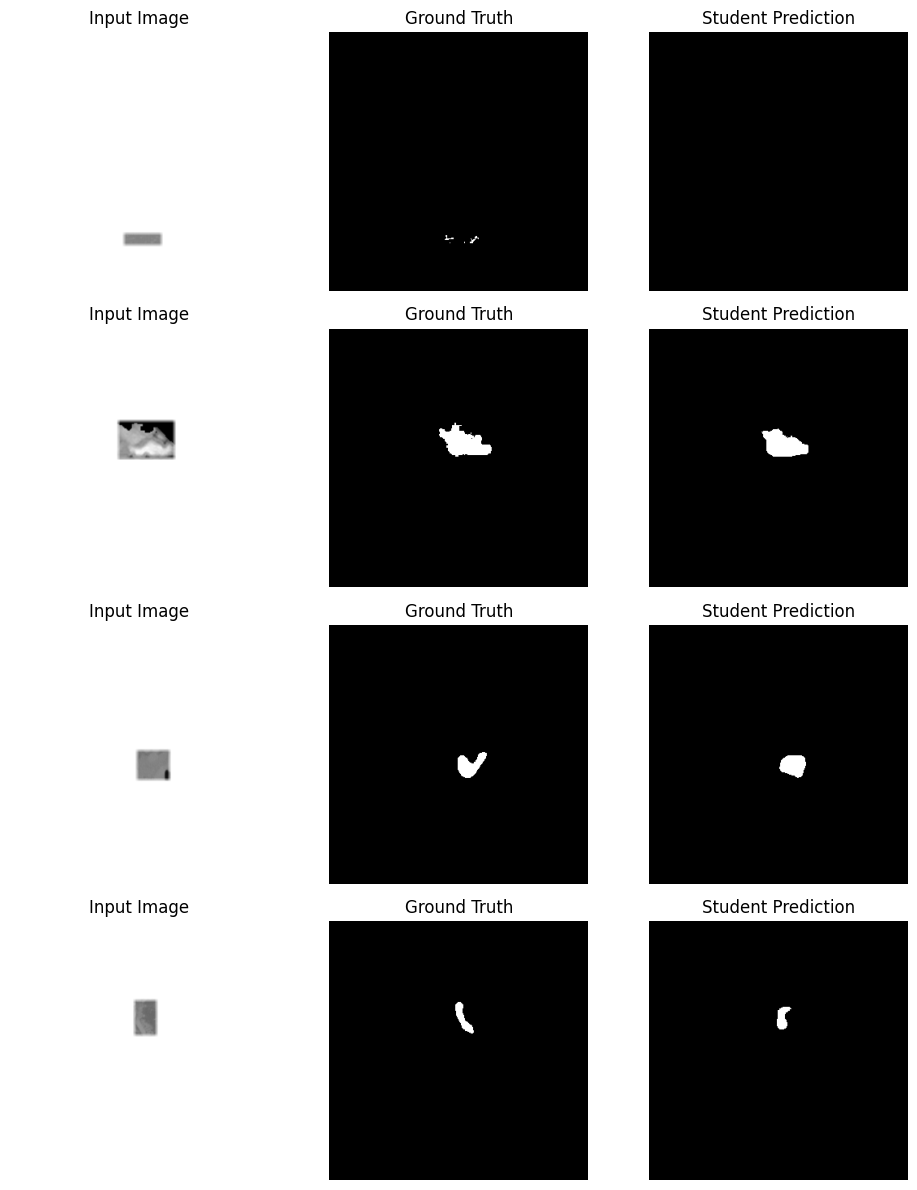

In [28]:
# =====================================================
# 🎨 Visualize Random Predictions (Fixed for mask dims)
# =====================================================
import matplotlib.pyplot as plt
import random
import torch

student_model.eval()
num_samples = 4
indices = random.sample(range(len(val_loader.dataset)), num_samples)

fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

for i, idx in enumerate(indices):
    sample = val_loader.dataset[idx]
    img = sample["image"].unsqueeze(0).to(device)
    mask = sample["mask"].cpu().squeeze().numpy()  # ✅ remove (1, H, W) → (H, W)

    with torch.no_grad(), torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
        pred = torch.sigmoid(student_model(img)).cpu().squeeze().numpy()

    axes[i, 0].imshow(sample["image"].permute(1, 2, 0))
    axes[i, 0].set_title("Input Image")
    axes[i, 1].imshow(mask, cmap="gray")  # ✅ now 2D
    axes[i, 1].set_title("Ground Truth")
    axes[i, 2].imshow(pred > 0.5, cmap="gray")
    axes[i, 2].set_title("Student Prediction")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()


In [29]:
# =====================================================
# 💾 Save full fine-tuned model object
# =====================================================
FULL_MODEL_PATH = "/kaggle/working/student_finetuned_full.pt"

# Ensure model is on CPU before saving to avoid GPU-specific serialization
student_model_cpu = student_model.to("cpu")

torch.save(student_model_cpu, FULL_MODEL_PATH)
print(f"✅ Full model saved at: {FULL_MODEL_PATH}")


✅ Full model saved at: /kaggle/working/student_finetuned_full.pt
